<a href="https://colab.research.google.com/github/TomazFilgueira/UFRN-ML-2025-1-Heart_Disease_Classfication/blob/main/heart_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

%matplotlib inline
plt.style.use('fivethirtyeight')


## Architeture Classs


In [4]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename,weights_only=False)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

#Read Reduced CSV File from Github

In [14]:
import pandas as pd

url = "https://raw.githubusercontent.com/TomazFilgueira/UFRN-ML-2025-1-Heart_Disease_Classfication/main/0_data/reduced_heart_disease_dataset.csv" # Correct URL to raw file content

try:
  df = pd.read_csv(url)
  print("Successfully read CSV from GitHub")
  # Now you can work with the DataFrame 'df'
  print(df.head()) # Example: Display the first few rows

except Exception as e:
  print(f"An error occurred: {e}")

Successfully read CSV from GitHub
   age     sex                cp  trestbps  chol  fbs                restecg  \
0   63    Male      Asymptomatic       145   233    1                 Normal   
1   37    Male  Non-anginal pain       130   250    0  ST-T wave abnormality   
2   41  Female   Atypical angina       130   204    0                 Normal   
3   56    Male   Atypical angina       120   236    0  ST-T wave abnormality   
4   57  Female    Typical angina       120   354    0  ST-T wave abnormality   

   thalachh exang  oldpeak        slope  ca          thal  target elderly  
0       150    No      2.3    Upsloping   0        Normal       1    >=60  
1       187    No      3.5    Upsloping   0  Fixed defect       1     <60  
2       172    No      1.4  Downsloping   0  Fixed defect       1     <60  
3       178    No      0.8  Downsloping   0  Fixed defect       1     <60  
4       163   Yes      0.6  Downsloping   0  Fixed defect       1     <60  


After this points we will pass for a series of checkpoint in order to get our dataset classified using pytorch.

Those checkpoints are:

1.  Data Preparation:
  * Create dummy variables
  * Creator tensors
  * build train and validation dataset/dataloader

2. Configure Model: determine some parameters:
  * Which model should we use to classify binary output?
  * Defines Stocastic Gradient Descent
  * Defines a loss function to classification

3. Train the model itself using `Architeture()` class

4. Validate the Model:
  * is the model accurate to our problem?
  * Let's evaluate some metrics such as:
    - Recall/Precision
    - Accuracy
    - True and False Positive Rates

4. Make Predictions

#1) Data Preparation

Most of work has been done during the EDA parts. However, something must be adapted in order to our classify works properly

First we need to convert categorical features into dummy ones.

In [26]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal,target,elderly
0,63,Male,Asymptomatic,145,233,1,Normal,150,No,2.3,Upsloping,0,Normal,1,>=60
1,37,Male,Non-anginal pain,130,250,0,ST-T wave abnormality,187,No,3.5,Upsloping,0,Fixed defect,1,<60
2,41,Female,Atypical angina,130,204,0,Normal,172,No,1.4,Downsloping,0,Fixed defect,1,<60
3,56,Male,Atypical angina,120,236,0,ST-T wave abnormality,178,No,0.8,Downsloping,0,Fixed defect,1,<60
4,57,Female,Typical angina,120,354,0,ST-T wave abnormality,163,Yes,0.6,Downsloping,0,Fixed defect,1,<60


In [27]:
# prompt: create dummies features

# Create dummy variables for categorical features
categorical_cols = ['sex','cp', 'restecg', 'exang', 'slope','thal','elderly']
df_dummy = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print(df_dummy.shape)

(424, 20)


##Balanced target column
One of the biggest mistakes in classification problem is to let train and validation dataset with disproportional values of our target column.

because of that we will calculate the proportion of target in the main dataset and will leave with same ratio in train and validation division.


In [17]:
# Calculate target proportion
target_proportion = df['target'].value_counts(normalize=True)
target_proportion


,proportion
target,
0,0.575472
1,0.424528


##Creating tensors and building train/validation dataset

In [22]:
# Define features (X) and target (y)
X = df_dummy.drop('target', axis=1).values
y = df_dummy['target'].values

# Scale features using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and validation sets while maintaining target proportion
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=df_dummy['target'])

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)  # Reshape for single output
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders in mini_batch type with 16 observations
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [23]:
# Calculate the proportion of True values in y_train
true_proportion_train = np.sum(y_train) / len(y_train)

# Calculate the proportion of True values in y_val
true_proportion_val = np.sum(y_val) / len(y_val)

print(f"Proportion of True values in y_train: {true_proportion_train}")
print(f"Proportion of True values in y_val: {true_proportion_val}")


Proportion of True values in y_train: 0.42567567567567566
Proportion of True values in y_val: 0.421875


The code above is just to be sure that our stratification in target column is made correctly.

The proportion of true values in train and validation dataset is the same of the original dataframe

#2) Configure Model

In this section we will configure our classification model.

Starting with the following hyper-parameters:
* lr = 0.1
* model: linear with 19 predictors (dataset features exluding target column)
* Optimizer: Stochastic Gradient Descent
* Loss Function: Binary-Cross Entropy with Logit Loss. This loss function is widely used in classification problems because its output means probabilities of an event to happen


In [55]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.05

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(19, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

#3)Training

In [56]:
#set number of epochs
n_epochs = 100

#using Architecture class passing model, loss and optimized as parameters
arch = Architecture(model, loss_fn, optimizer)
arch.set_loaders(train_loader, val_loader)
arch.set_seed(42)
arch.train(n_epochs)


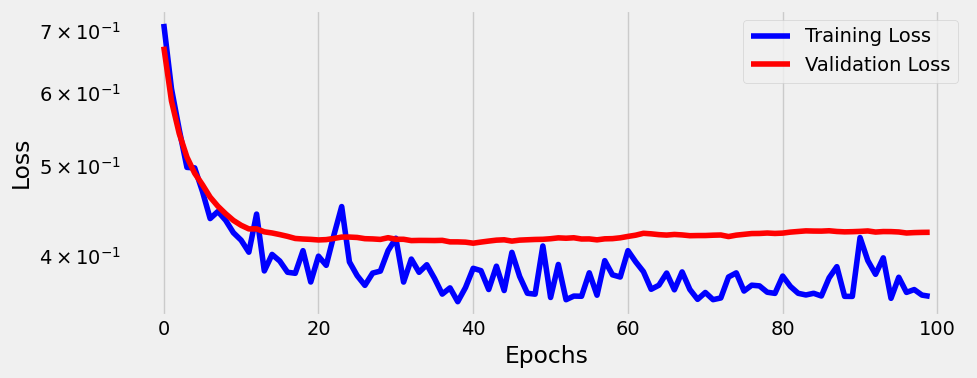

In [57]:
fig = arch.plot_losses()

From the figure above we can see the lines of training and validation loss.

It is ease to see that our model did not overfitted because the error of train/validation remained similar throughout the epochs. However, the validation error itself can be optimized.

In [36]:
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[ 0.3303, -0.2085,  0.0616,  0.2493,  0.1211,  0.0077, -0.5556,  0.1082,
          0.0292,  0.2037, -0.3766,  0.4214,  0.8433, -0.3807, -0.6420, -0.2177,
         -0.1465, -1.3791, -0.2872]], device='cuda:0')), ('linear.bias', tensor([-0.3827], device='cuda:0'))])
